<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Analyzing-an-initial-dataset" data-toc-modified-id="Analyzing-an-initial-dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Analyzing an initial dataset</a></span></li><li><span><a href="#Data-format" data-toc-modified-id="Data-format-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data format</a></span></li><li><span><a href="#Data-quality" data-toc-modified-id="Data-quality-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data quality</a></span></li><li><span><a href="#Data-quantity-and-distribution" data-toc-modified-id="Data-quantity-and-distribution-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data quantity and distribution</a></span></li></ul></div>

# Analyzing an initial dataset
In this notebook, we will quickly explore a real dataset of questions from writers.stackexchange.com. The dataset was initially sourced from the archive.

First, we will load the data. If you are loading a different csv, make sure you have pre-processed the raw xml using the ml_editor python package.

In [1]:
import json
from tqdm import tqdm
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ElT
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd

from pathlib import Path
import sys

# import warnings
# warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

df = pd.read_csv(Path('../raw_data/writers.csv'))

# Data format

Let's start by thinking through how we would like to format the data. Amongst other decisions, we will need to decide which label we should give our model.

We want a model that measures the quality of a question. To that end, we could use:

The number of upvotes a question gets
The number of answers a question gets, or whether they get an answer at all
Whether an answer was marked as accepted or not
First, let's format our dataset to reconcile questions and associated answers, and verify that they match up.

We will start by filling missing values, as well as adding two features (text_len and is_question) we will use later.

In [3]:
df.head(2)

,Unnamed: 0,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CommunityOwnedDate,ContentLicense,CreationDate,FavoriteCount,...,LastEditorUserId,OwnerDisplayName,OwnerUserId,ParentId,PostTypeId,Score,Tags,Title,ViewCount,body_text
0,0,15.0,10.0,<p>I've always wanted to start writing (in a t...,2019-09-09T15:44:30.727,7,NaN,CC BY-SA 3.0,2010-11-18T20:40:32.857,19.0,...,32946.0,NaN,8.0,NaN,1,32,<resources><first-time-author>,What are some online guides for starting writers?,1470.0,I've always wanted to start writing (in a tota...
1,1,16.0,7.0,<p>What kind of story is better suited for eac...,NaN,0,NaN,CC BY-SA 3.0,2010-11-18T20:42:31.513,5.0,...,NaN,NaN,8.0,NaN,1,23,<fiction><grammatical-person><third-person>,What is the difference between writing in the ...,9660.0,What kind of story is better suited for each p...


In [4]:
# Start by changing types to make processing easier

df['AnswerCount'] = df['AnswerCount'].fillna(-1)
df['AnswerCount'] = df['AnswerCount'].astype(int)

df['PostTypeId'] = df['PostTypeId'].astype(int)
df['Id'] = df['Id'].astype(int)
df.set_index("Id", inplace=True, drop=False)

# Add measure of the length of a post
df['full_text'] = df['Title'].str.cat(df['body_text'], sep = ' ', na_rep = ' ')
df['text_len'] = df['full_text'].str.len()

# A question is a post of id 1
df['is_question'] = df["PostTypeId"] == 1

In [5]:
df.tail(2)

,Unnamed: 0,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CommunityOwnedDate,ContentLicense,CreationDate,FavoriteCount,...,ParentId,PostTypeId,Score,Tags,Title,ViewCount,body_text,full_text,text_len,is_question
Id,,,,,,,,,,,,,,,,,,,,,
53933,43843,NaN,-1,<p><em><strong>A few Ideas:</strong></em></p>\...,NaN,1,NaN,CC BY-SA 4.0,2020-12-05T06:57:26.703,NaN,...,53929.0,2,1,NaN,NaN,NaN,A few Ideas:\nThis is slightly borderline aski...,A few Ideas:\nThis is slightly borderline as...,1233,False
53935,43844,NaN,0,<p>I have just started a blog on which I publi...,2020-12-05T15:30:34.110,0,NaN,CC BY-SA 4.0,2020-12-05T13:59:26.910,NaN,...,NaN,1,-1,<fiction><short-story><pov>,Can we share our own stories?,9.0,I have just started a blog on which I publish ...,Can we share our own stories? I have just star...,562,True


# Data quality

Let's examine the quality of the data in this dataset, starting by answering the questions below

- How much of the data is missing?
- What is the quality of the text?
- Do the answers match the questions?

In [9]:
# Start by displaying columns and counts of non-null entries
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43845 entries, 1 to 53935
Data columns (total 27 columns):
Unnamed: 0               43845 non-null int64
AcceptedAnswerId         5191 non-null float64
AnswerCount              43845 non-null int32
Body                     43760 non-null object
ClosedDate               1344 non-null object
CommentCount             43845 non-null int64
CommunityOwnedDate       197 non-null object
ContentLicense           43845 non-null object
CreationDate             43845 non-null object
FavoriteCount            4107 non-null float64
Id                       43845 non-null int32
LastActivityDate         43845 non-null object
LastEditDate             15601 non-null object
LastEditorDisplayName    996 non-null object
LastEditorUserId         14780 non-null float64
OwnerDisplayName         3468 non-null object
OwnerUserId              40820 non-null float64
ParentId                 32851 non-null float64
PostTypeId               43845 non-null int32
Score 

We have a ~44.000 posts which consist of both questions and answers.

Looking at the Body column, it appears that it is null in 43845 - 43760 = 85 rows. Let's take a look at these rows to see if we should remove them.

In [12]:
df[df['Body'].isna()]

,Unnamed: 0,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CommunityOwnedDate,ContentLicense,CreationDate,FavoriteCount,...,ParentId,PostTypeId,Score,Tags,Title,ViewCount,body_text,full_text,text_len,is_question
Id,,,,,,,,,,,,,,,,,,,,,
2145,1957,NaN,-1,NaN,NaN,0,NaN,CC BY-SA 2.5,2011-03-22T19:49:56.600,NaN,...,NaN,5,0,NaN,NaN,NaN,NaN,,3,False
2147,1959,NaN,-1,NaN,NaN,0,NaN,CC BY-SA 2.5,2011-03-22T19:51:05.897,NaN,...,NaN,5,0,NaN,NaN,NaN,NaN,,3,False
2215,2027,NaN,-1,NaN,NaN,0,NaN,CC BY-SA 2.5,2011-03-24T19:35:10.353,NaN,...,NaN,5,0,NaN,NaN,NaN,NaN,,3,False
2218,2030,NaN,-1,NaN,NaN,0,NaN,CC BY-SA 2.5,2011-03-24T19:41:38.677,NaN,...,NaN,5,0,NaN,NaN,NaN,NaN,,3,False
2225,2037,NaN,-1,NaN,NaN,0,NaN,CC BY-SA 2.5,2011-03-24T19:58:59.833,NaN,...,NaN,5,0,NaN,NaN,NaN,NaN,,3,False
2227,2039,NaN,-1,NaN,NaN,0,NaN,CC BY-SA 2.5,2011-03-24T20:05:07.753,NaN,...,NaN,5,0,NaN,NaN,NaN,NaN,,3,False
2233,2045,NaN,-1,NaN,NaN,0,NaN,CC BY-SA 2.5,2011-03-24T20:22:44.603,NaN,...,NaN,5,0,NaN,NaN,NaN,NaN,,3,False
3138,2848,NaN,-1,NaN,NaN,0,NaN,CC BY-SA 3.0,2011-06-19T20:18:13.253,NaN,...,NaN,5,0,NaN,NaN,NaN,NaN,,3,False
5148,4656,NaN,-1,NaN,NaN,0,NaN,CC BY-SA 3.0,2012-03-03T21:24:29.283,NaN,...,NaN,5,0,NaN,NaN,NaN,NaN,,3,False


In [17]:
tmp = df[df['Body'].isna()]
tmp['PostTypeId'].value_counts()

5    83
4     2
Name: PostTypeId, dtype: int64

All of the null bodys are of PostTypeId 4 or 5.

The readme file that accompanied the archive only mentions PostTypeIds of 1 (questions) and 2 (answers). We will remove all rows not marked PostTypeId 1 or 2, since we are only interested in questions and answers.

In [18]:
df = df[df["PostTypeId"].isin([1,2])]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43106 entries, 1 to 53935
Data columns (total 27 columns):
Unnamed: 0               43106 non-null int64
AcceptedAnswerId         5191 non-null float64
AnswerCount              43106 non-null int32
Body                     43106 non-null object
ClosedDate               1344 non-null object
CommentCount             43106 non-null int64
CommunityOwnedDate       190 non-null object
ContentLicense           43106 non-null object
CreationDate             43106 non-null object
FavoriteCount            4107 non-null float64
Id                       43106 non-null int32
LastActivityDate         43106 non-null object
LastEditDate             14862 non-null object
LastEditorDisplayName    988 non-null object
LastEditorUserId         14048 non-null float64
OwnerDisplayName         3463 non-null object
OwnerUserId              40086 non-null float64
ParentId                 32851 non-null float64
PostTypeId               43106 non-null int32
Score 

Now let's look at a few questions and answers and verify that they match, and that the text is readable.

In [24]:
questions_with_accepted_answers = df[df['is_question'] & ~(df['AcceptedAnswerId'].isna())]

In [25]:
q_and_a = questions_with_accepted_answers.join(df['body_text'], on='AcceptedAnswerId', how='left', rsuffix='_answer')

In [26]:
# Setting this option allows us to display all the data
pd.options.display.max_colwidth = 500
q_and_a[['body_text', 'body_text_answer']][:3]

,body_text,body_text_answer
Id,,
1,"I've always wanted to start writing (in a totally amateur way), but whenever I want to start something I instantly get blocked having a lot of questions and doubts.\nAre there some resources on how to start becoming a writer?\nI'm thinking something with tips and easy exercises to get the ball rolling.\n","When I'm thinking about where I learned most how to write, I think that reading was the most important guide to me. This may sound silly, but by reading good written newspaper articles (facts, opinions, scientific articles and most of all, criticisms of films and music), I learned how others did the job, what works and what doesn't. In my own writing, I try to mimic other people's styles that I liked. Moreover, I learn new things by reading, giving me a broader background that I need when re..."
2,"What kind of story is better suited for each point of view? Are there advantages or disadvantages inherent to them?\nFor example, writing in the first person you are always following a character, while in the third person you can ""jump"" between story lines.\n","With a story in first person, you are intending the reader to become much more attached to the main character. Since the reader sees what that character sees and feels what that character feels, the reader will have an emotional investment in that character. Third person does not have this close tie; a reader can become emotionally invested but it will not be as strong as it will be in first person.\nContrarily, you cannot have multiple point characters when you use first person without ex..."
3,"I finished my novel, and everyone I've talked to says I need an agent. How do I find one?\n","Try and find a list of agents who write in your genre. Check out their websites!\nFind out if they are accepting new clients. If they aren't, then check out another agent. But if they are, try sending them a few chapters from your story, a brief, and a short cover letter asking them to represent you.\nIn the cover letter mention your previous publication credits. If sent via post, then I suggest you give them a means of reply, whether it be an email or a stamped, addressed envelope.\nAgents ..."


In [27]:
q_and_a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5191 entries, 1 to 53912
Data columns (total 28 columns):
Unnamed: 0               5191 non-null int64
AcceptedAnswerId         5191 non-null float64
AnswerCount              5191 non-null int32
Body                     5191 non-null object
ClosedDate               409 non-null object
CommentCount             5191 non-null int64
CommunityOwnedDate       10 non-null object
ContentLicense           5191 non-null object
CreationDate             5191 non-null object
FavoriteCount            2427 non-null float64
Id                       5191 non-null int32
LastActivityDate         5191 non-null object
LastEditDate             3296 non-null object
LastEditorDisplayName    96 non-null object
LastEditorUserId         3215 non-null float64
OwnerDisplayName         257 non-null object
OwnerUserId              5068 non-null float64
ParentId                 0 non-null float64
PostTypeId               5191 non-null int32
Score                    51

So far so good, the **questions and answers seem to match**, and the text seems coherent and human readable except for unescaped newlines characters ("\n").

Let's add to each row representing an answer information about the question it was answering.

In [29]:
df = df.join(df[['Id', 'Title', 'body_text', 'text_len', 'Score', 'AcceptedAnswerId']], on='ParentId', how='left', rsuffix='_question')

This allows us to see all answers for a given question like so

In [31]:
df[df["Id_question"] ==1].head(2)

,Unnamed: 0,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CommunityOwnedDate,ContentLicense,CreationDate,FavoriteCount,...,body_text,full_text,text_len,is_question,Id_question,Title_question,body_text_question,text_len_question,Score_question,AcceptedAnswerId_question
Id,,,,,,,,,,,,,,,,,,,,,
8,5,NaN,-1,"<p>BeginningWriters.com has some good articles for beginning writers.</p>\n\n<p><a href=""http://beginningwriters.com/"">http://beginningwriters.com/</a></p>\n",NaN,0,NaN,CC BY-SA 2.5,2010-11-18T20:45:45.533,NaN,...,BeginningWriters.com has some good articles for beginning writers.\nhttp://beginningwriters.com/\n,BeginningWriters.com has some good articles for beginning writers.\nhttp://beginningwriters.com/\n,98,False,1.0,What are some online guides for starting writers?,"I've always wanted to start writing (in a totally amateur way), but whenever I want to start something I instantly get blocked having a lot of questions and doubts.\nAre there some resources on how to start becoming a writer?\nI'm thinking something with tips and easy exercises to get the ball rolling.\n",352.0,32.0,15.0
15,10,NaN,-1,"<p>When I'm thinking about where I learned most how to write, I think that <em>reading</em> was the most important guide to me. This may sound silly, but by reading good written newspaper articles (facts, opinions, scientific articles and most of all, criticisms of films and music), I learned how others did the job, what works and what doesn't. In my own writing, I try to mimic other people's styles that I liked. Moreover, I learn new things by reading, giving me a broader background that I ...",NaN,3,NaN,CC BY-SA 2.5,2010-11-18T20:50:16.683,NaN,...,"When I'm thinking about where I learned most how to write, I think that reading was the most important guide to me. This may sound silly, but by reading good written newspaper articles (facts, opinions, scientific articles and most of all, criticisms of films and music), I learned how others did the job, what works and what doesn't. In my own writing, I try to mimic other people's styles that I liked. Moreover, I learn new things by reading, giving me a broader background that I need when re...","When I'm thinking about where I learned most how to write, I think that reading was the most important guide to me. This may sound silly, but by reading good written newspaper articles (facts, opinions, scientific articles and most of all, criticisms of films and music), I learned how others did the job, what works and what doesn't. In my own writing, I try to mimic other people's styles that I liked. Moreover, I learn new things by reading, giving me a broader background that I need when ...",963,False,1.0,What are some online guides for starting writers?,"I've always wanted to start writing (in a totally amateur way), but whenever I want to start something I instantly get blocked having a lot of questions and doubts.\nAre there some resources on how to start becoming a writer?\nI'm thinking something with tips and easy exercises to get the ball rolling.\n",352.0,32.0,15.0


# Data quantity and distribution

Now that we have linked questions and answers, and verified data quality, let's produce some summary statistics.

- How many questions are in the dataset?
- How many questions received answers?
- How long do questions tend to be?

In [33]:
has_accepted_answer = df[df['is_question'] & ~(df['AcceptedAnswerId'].isna())]
received_answers = df[df['is_question'] & (df['AnswerCount'] != 0)]
no_answers = df[df['is_question'] & (df['AcceptedAnswerId'].isna()) & (df['AnswerCount'] == 0)]

In [35]:
print('%s total questions \n %s received at least one answer \n %s received accpeted answer ' % (
      len(df[df['is_question']]),
      len(received_answers),
      len(has_accepted_answer)))

10255 total questions 
 9985 received at least one answer 
 5191 received accpeted answer 


Most questions have an answer, and only half of those answers have been accepted. Whether a question received an accepted answer could be a good label.

Another potential label would be the number of upvotes a question received, denoted in the Score column. This label is helpful because we can either treat it as a binary (whether the score is higher or lower than the median) or continuous depending on how granular we would like our model to be.I've plotted the score distribution below.

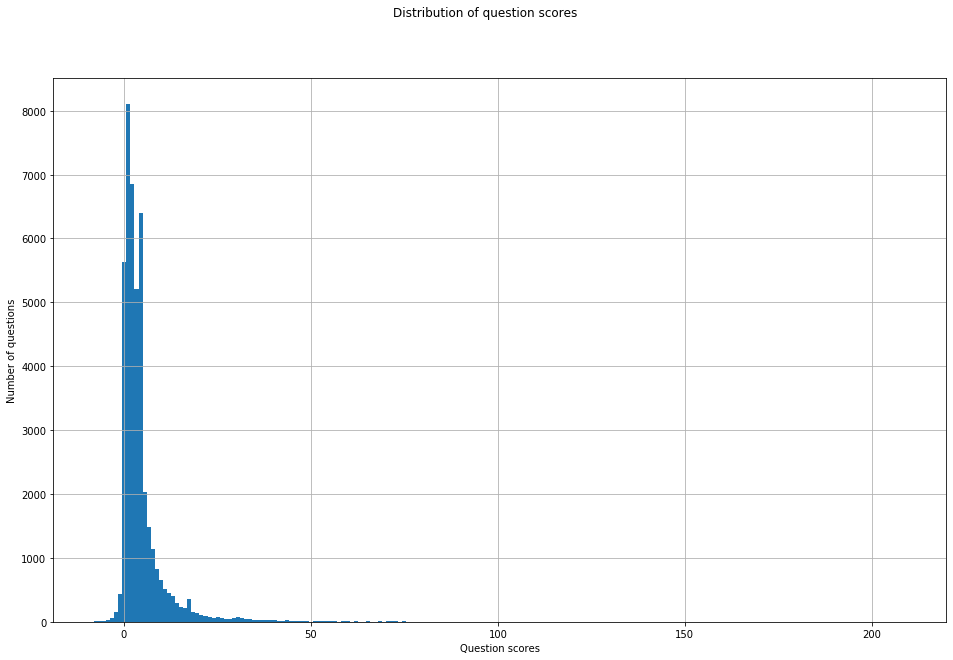

In [36]:
fig = plt.figure(figsize=(16,10))
fig.suptitle('Distribution of question scores')
plt.xlabel('Question scores')
plt.ylabel('Number of questions')
df['Score'].hist(bins=200)

Let's dive more into the questions by looking at potential predictive features, such as question length. How long are the questions in our dataset?

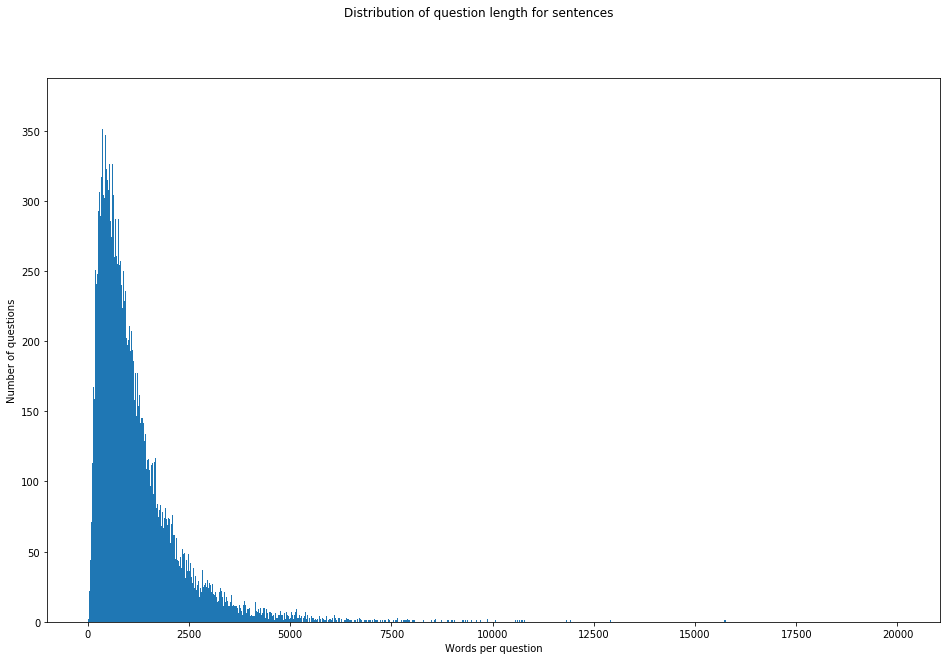

In [38]:
fig = plt.figure(figsize=(16,10))
fig.suptitle('Distribution of question length for sentences')
plt.xlabel('Words per question')
plt.ylabel('Number of questions')
q_len = plt.hist(df['text_len'], bins=2000, log=False)

Only a few outliers seem to contain more than two thousand words. Let's zoom in to the shorter questions on the graph.

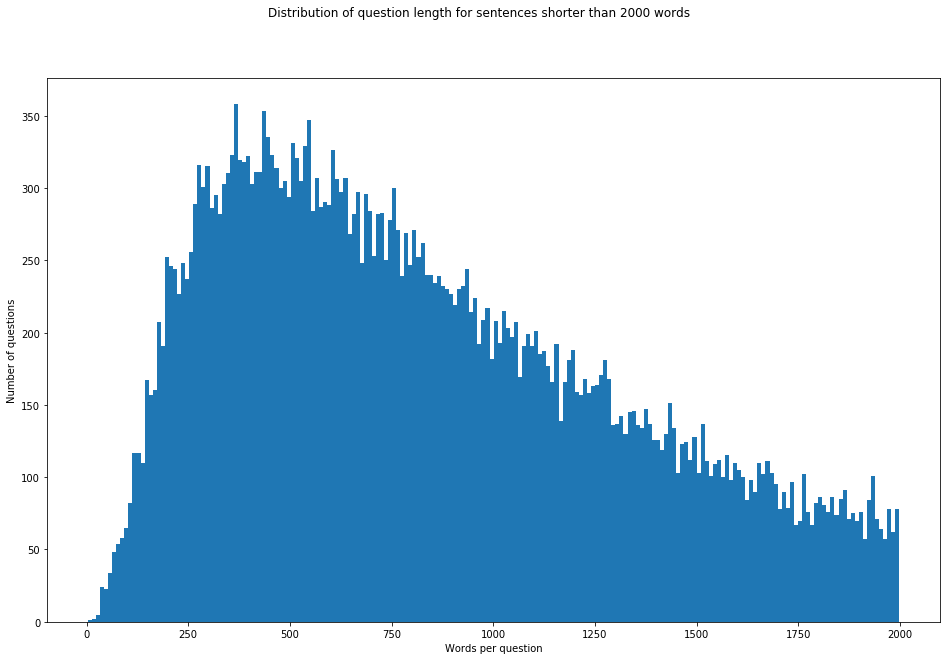

In [39]:
fig = plt.figure(figsize=(16, 10))
fig.suptitle('Distribution of question length for sentences shorter than 2000 words')
plt.xlabel('Words per question')
plt.ylabel('Number of questions')
q_len_trunc = plt.hist(df[df['text_len'] < 2000]['text_len'], bins = 200, log = False)

Now is sentence length predictive of getting many upvotes?

In order to start answering this question, we can update this plot to overlay the distributions for both high and low score questions.

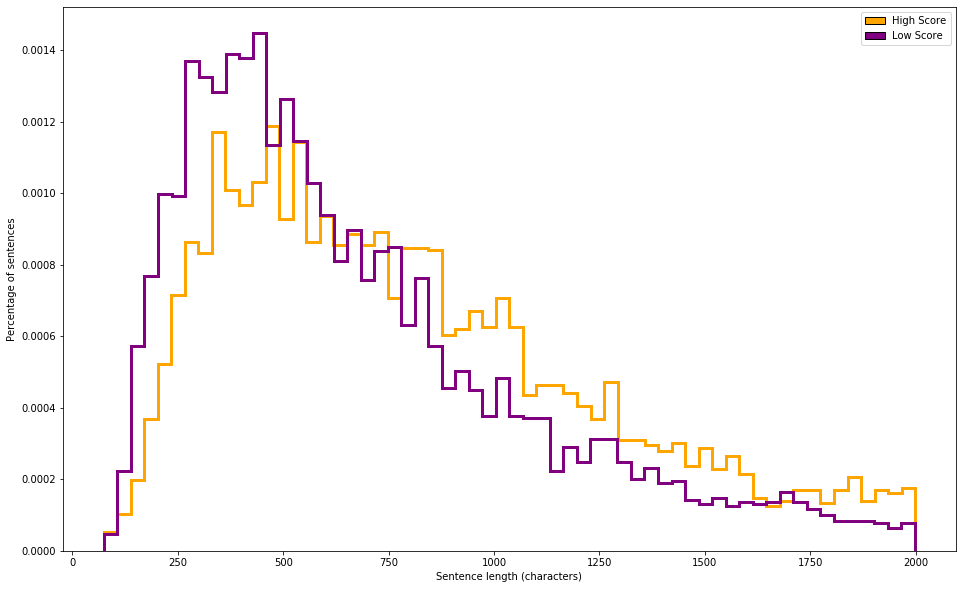

In [40]:
high_score = df['Score'] > df['Score'].median()

# We filter out really long questions
normal_length = df['text_len'] < 2000

ax = df[df['is_question'] & high_score & normal_length]['text_len'].hist(
    bins=60,
    density=True,
    histtype='step',
    color='orange',
    linewidth=3,
    grid=False,
    figsize=(16, 10)
)

ay = df[df['is_question'] & ~high_score & normal_length]['text_len'].hist(
    bins=60,
    density=True,
    histtype='step',
    color='purple',
    linewidth=3,
    grid=False,
)

handles = [
    Rectangle((0, 0), 1, 1, color=c, ec='k') for c in ['orange', 'purple']
]

labels = ['High Score', 'Low Score']
plt.legend(handles, labels)
ax.set_xlabel('Sentence length (characters)')
ax.set_ylabel('Percentage of sentences');

It seems that there may be a relatively higher proportion of very short questions amongst unanswered ones. Questions with high scores tend to be longer on average. This makes question length a feature candidate that we should try for our model.

Going back to using "received answers" as a measure of quality, let's look at the number of answers questions get, and more precisely the distribution of the quantity of answers.

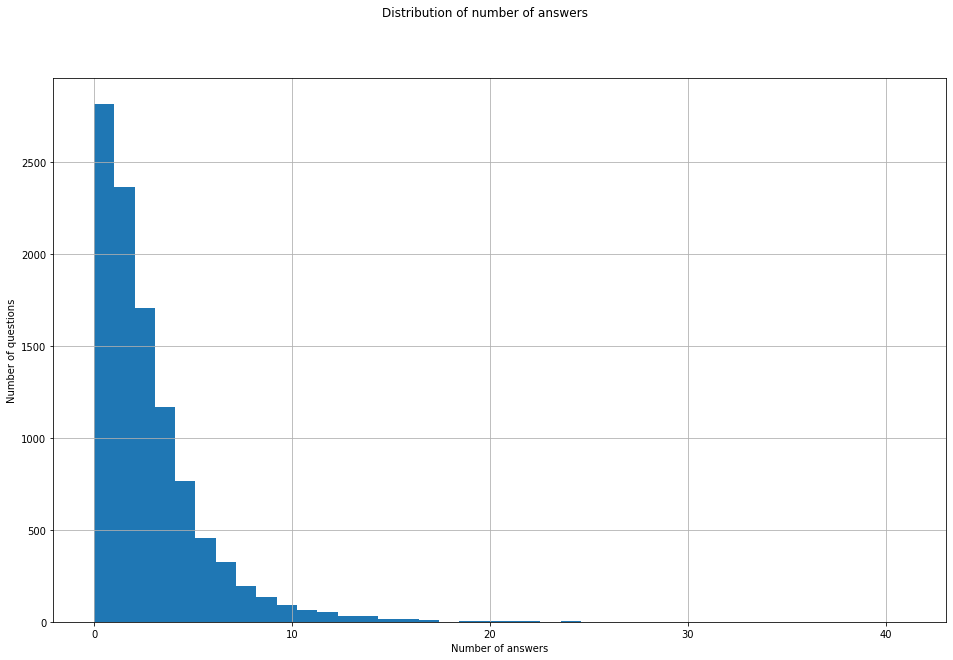

In [41]:
fig = plt.figure(figsize=(16,10))
fig.suptitle('Distribution of number of answers')
plt.xlabel('Number of answers')
plt.ylabel('Number of questions')
hist = df[df['is_question']]['AnswerCount'].hist(bins=40)

Let's see if questions with high scores tend to get more answers.

First, let's plot one as a function of the other, and see whether we can establish a trend.

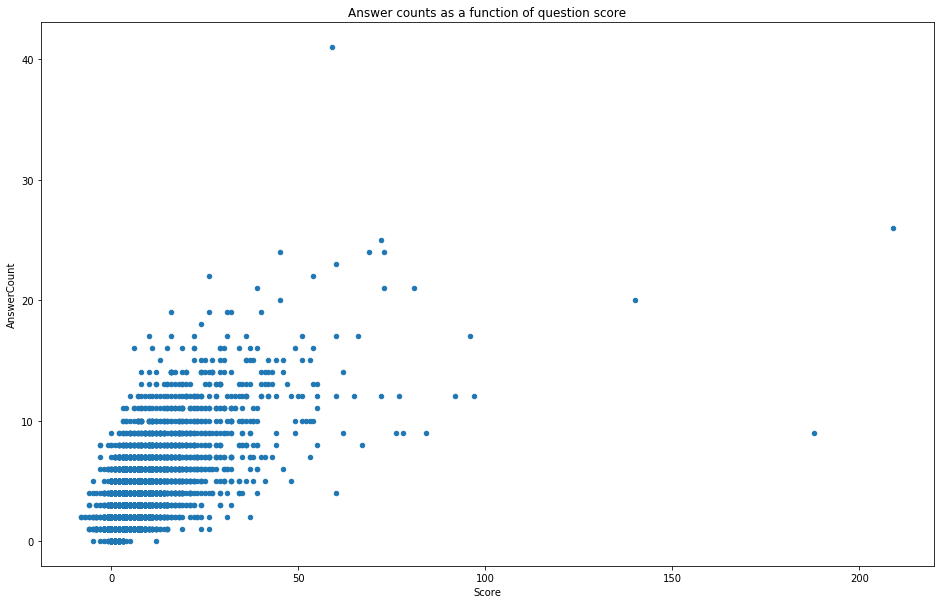

In [42]:
scatter = df[df['is_question']][['Score', 'AnswerCount']].plot(x='Score', y='AnswerCount',
                                                              kind='Scatter',
                                                              figsize=(16, 10))

ax.set_xlabel('Score')
ax.set_ylabel('Num answers')
scatter.set_title('Answer counts as a function of question score');

Scores and number of answers seem correlated. We mentioned above making the score into a binary label by using is_score_above_median as the label. Let's see how this label would correlate with the number of answers by plotting histograms of the numbers of answers a question gets for question in each category (score above and below the median)

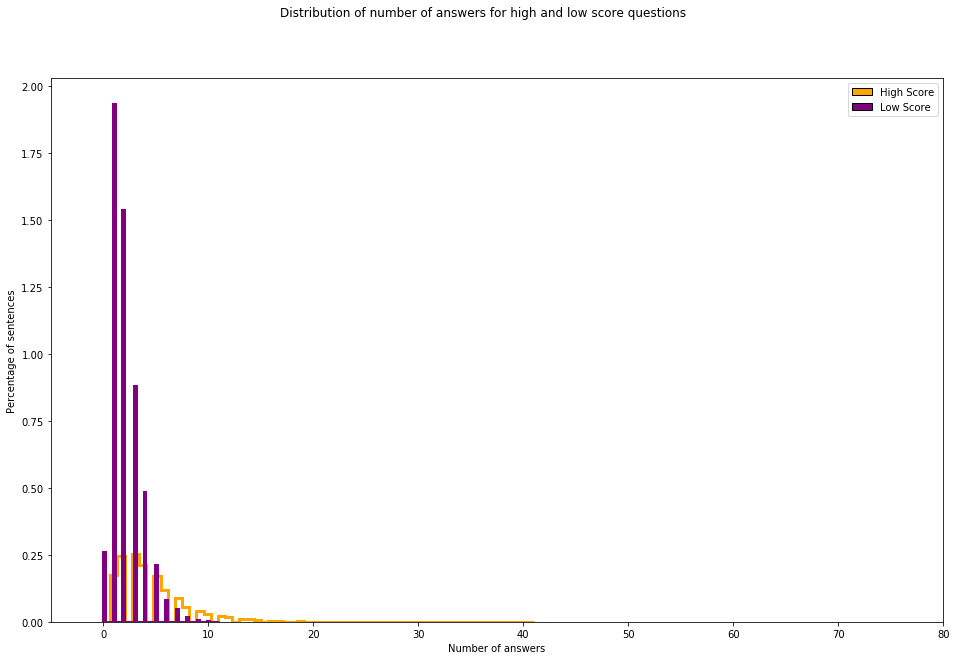

In [43]:
fig = plt.figure(figsize=(16, 10))
fig.suptitle('Distribution of number of answers for high and low score questions')
plt.xlim(-5, 80)

ax = df[df['is_question'] & 
       (df['Score'] > df['Score'].median())]['AnswerCount'].hist(
                                                        bins=60,
                                                        density=True,
                                                        histtype='step',
                                                        color='orange',
                                                        linewidth=3,
                                                        grid=False,
                                                        figsize=(16, 10))

ay = df[df['is_question'] & 
       ~(df['Score'] > df['Score'].median())]['AnswerCount'].hist(
                                                        bins=60,
                                                        density=True,
                                                        histtype='step',
                                                        color='purple',
                                                        linewidth=3,
                                                        grid=False)


handles = [
    Rectangle((0, 0), 1, 1, color=c, ec='k') for c in ['orange', 'purple']
]

labels = ['High Score', 'Low Score']
plt.legend(handles, labels)
ax.set_xlabel('Number of answers')
ax.set_ylabel('Percentage of sentences');       

It seems like questions that get a high score get more answers. The score of a question thus seems like a good initial label since it is more granular, but the number of answers would be a fine choice as well.

While it would make a good label, we cannot use the number of answers as a feature. This is because despite being correlated with the score, as the plot above shows, we will not have access to it at inference time, when we receive input from the users.

Since our model needs to work without having access to this input, we can either ignore it completely during training, or use it as a feature during training, and set the value of this feature as a constant in production. The first approach is simpler, but the second approach can help a model separate the effect of the "number of answers" feature from other style effects which we do want to capture. I'll let the reader experiment with both approaches.

After this summary exploration, we will see how to [split data](ch4_splitting_data.ipynb).